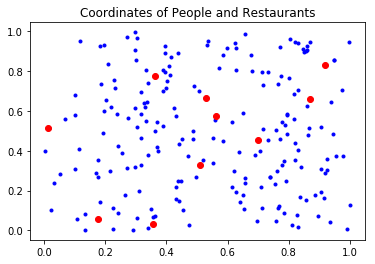

In [2]:
import numpy as np
import matplotlib.pyplot as plt

num_customer = 200
num_restaurants = 10
t_initial_period = 100
t_final = 365
p_going_restaurant = 0.7

# Create coordinates of customer and restaurants
coord_customer = np.random.rand(num_customer,2)
coord_restaurants = np.random.rand(num_restaurants,2)

plt.plot(coord_customer[:,0],coord_customer[:,1],'b.')
plt.plot(coord_restaurants[:,0],coord_restaurants[:,1],'ro')
plt.title("Coordinates of People and Restaurants")
plt.show()

In [3]:
# Distance and probability calcualtion for each customer
import scipy as sp
from scipy.spatial.distance import cdist
dist_customer_restaurants = cdist(coord_restaurants,coord_customer) # Pairwise Euclidean distance
dist_normalization = dist_customer_restaurants.sum(axis=0) #Normalize the distances

# Create separate probabilities for weekdays and weekends and add staying at home as a final probability
p_customer_restaurant_weekdays = np.divide(dist_customer_restaurants,dist_normalization)*p_going_restaurant
p_customer_restaurant_weekdays = np.concatenate((p_customer_restaurant_weekdays,np.full((1,num_customer),1-p_going_restaurant)))
p_customer_restaurant_weekends = np.divide(dist_customer_restaurants,dist_normalization)*p_going_restaurant/2
p_customer_restaurant_weekends = np.concatenate((p_customer_restaurant_weekends,np.full((1,num_customer),1-p_going_restaurant/2)))

In [4]:
idx_restaurans = np.arange(num_restaurants+1)
# visit_customer holds everyday visits for every customers. Rows are customers, columns are days
visit_customer = np.zeros((num_customer,t_initial_period))

# Create weekdays and weekends
i_days = np.arange(t_initial_period)
days_weekdays = i_days%7<5
days_weekends = np.invert(days_weekdays)

# Assign visits by sampling with replacement over visiting probabilities for every person
# Since visits are independent, all visits can be sampled simultaneously, given that probability distribution doesn't change
for i in range(num_customer):
    visit_customer[i,days_weekdays] = np.random.choice(idx_restaurans,np.sum(days_weekdays),p=p_customer_restaurant_weekdays[:,i])
    visit_customer[i,days_weekends] = np.random.choice(idx_restaurans,np.sum(days_weekends),p=p_customer_restaurant_weekends[:,i])


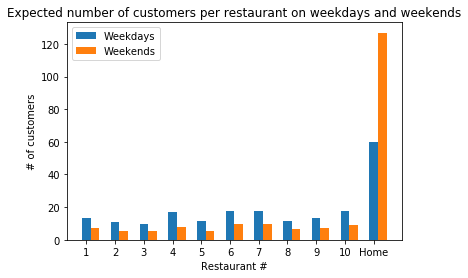

In [5]:
# Create Histogram for Weekdays and Weekends visit to see the probability change
H_weekdays, _ = np.histogram(visit_customer[:,days_weekdays],bins=num_restaurants+1)
H_weekends, _ = np.histogram(visit_customer[:,days_weekends],bins=num_restaurants+1)

# Normalize visit numbers by number of days to calculate a comparable metric
plt.bar(idx_restaurans,H_weekdays/np.sum(days_weekdays),0.3)
plt.bar(idx_restaurans+0.3,H_weekends/np.sum(days_weekends),0.3)
plt.title('Expected number of customers per restaurant per day on weekdays and weekends')
plt.xlabel('Restaurant #')
plt.ylabel('# of customers')
plt.legend(['Weekdays','Weekends'])
plt.xticks(idx_restaurans,[str(x) for x in range(1,num_restaurants+1)]+['Home'])
plt.show()

In [7]:
import pandas as pd
pd.DataFrame(visit_customer)